<a href="https://colab.research.google.com/github/tylerlum/traffic_signs/blob/master/Traffic_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Get traffic sign data
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.
signnames.csv  test.p  train.p	valid.p


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Keras
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

## Pickle and pandas
import pickle
import pandas as pd

## Random
import random
np.random.seed(0)

Using TensorFlow backend.


In [3]:
## Unpickle files
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
print(type(train_data))

## Get data and labels
X_train, Y_train = train_data['features'], train_data['labels']
X_val, Y_val = val_data['features'], val_data['labels']
X_test, Y_test = test_data['features'], test_data['labels']

## Check shape (number of pictures, width, height, RGB)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

<class 'dict'>
(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
## Check for bad data
assert(X_train.shape[0] == Y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == Y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == Y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"

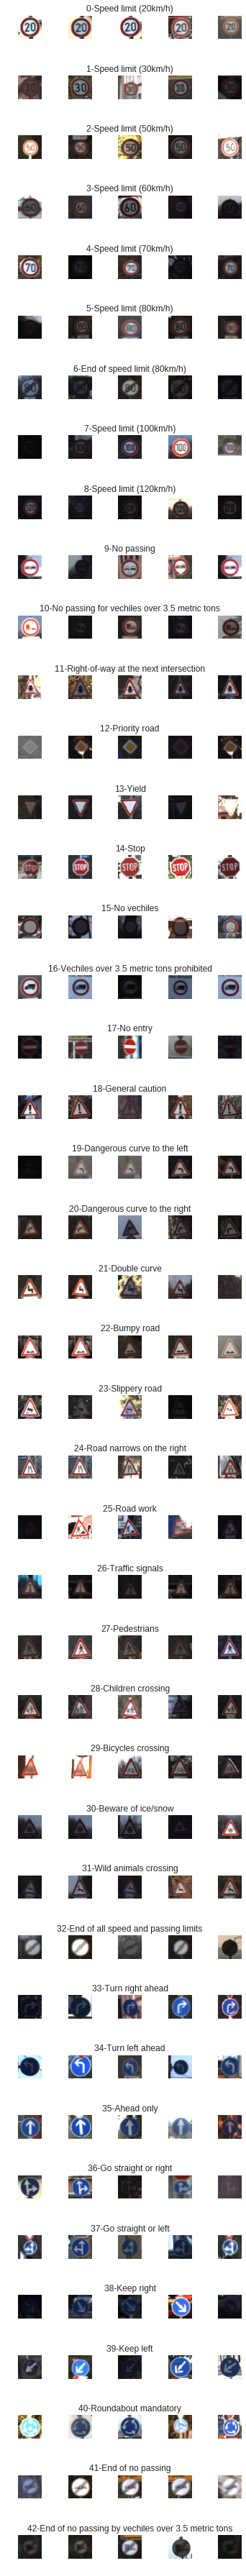

In [5]:
## Use pandas to import data from CSV file
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []

cols = 5
num_classes = data.shape[0]

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

## Iterate over dataframe rows as (index, Series)
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[Y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i == int(cols/2):
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


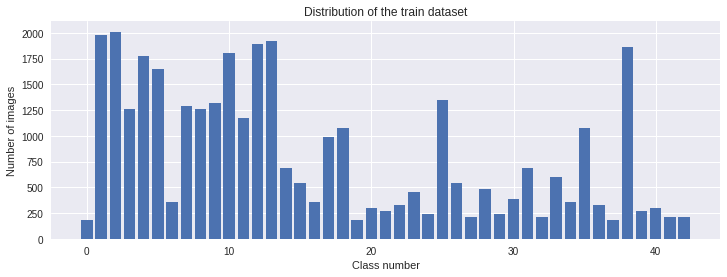

In [6]:
## Graph our data
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title('Distribution of the train dataset')
plt.xlabel('Class number')
plt.ylabel('Number of images')
plt.show()

In [0]:
## Preprocess images
import cv2

def grayscale(img):
  """Color not reliable because of different lighting. Convert to gray"""
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

def equalize(img):
  """Histogram Equalization (standardize lighting)"""
  img = cv2.equalizeHist(img)  # must be grayscale img
  return img

def preprocessing(img):
  """Grayscale, equalize and normalize"""
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)
(4410, 32, 32)
(12630, 32, 32)


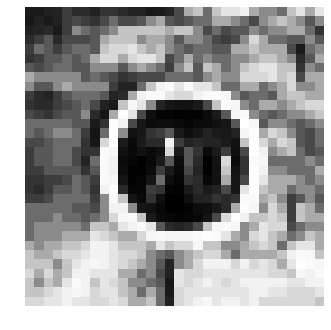

In [8]:
## Test preprocessing
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [9]:
## Reshape input data to have depth of 1
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

## One-Hot Encode outputs
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
def leNet_model():
  """LeNet Model"""
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [24]:
## Create leNet model
model = leNet_model()
print(model.summary())
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=400, verbose=1, shuffle=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 30)        16230     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 30)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               540500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
__________

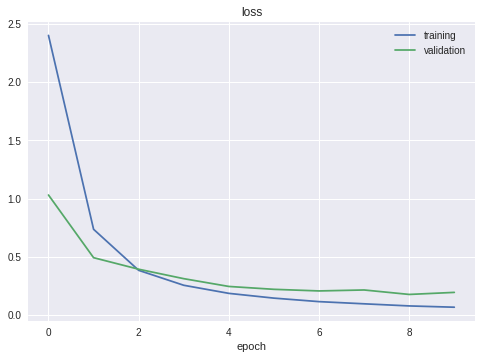

In [25]:
## Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

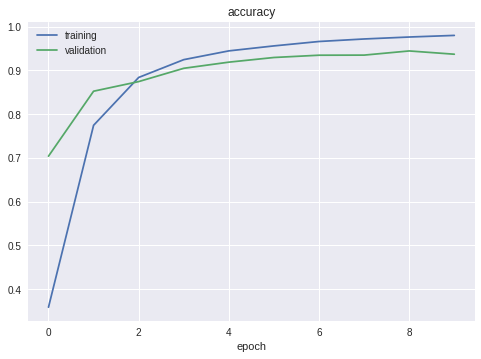

In [26]:
## Plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

In [27]:
score = model.evaluate(X_test, Y_test, verbose=0)

print("Test score:{0}".format(score[0]))
print("Test Accuracy:{0}".format(score[1]))

Test score:0.2852167628699602
Test Accuracy:0.9273159144798726
